In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
""" data generation
"""
 
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
    [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

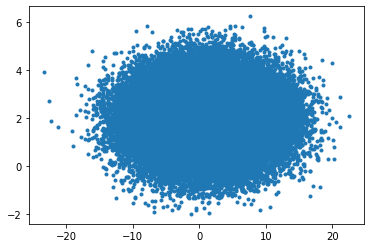

In [3]:
data1 = sample_data_1()
plt.scatter(data1[:, 0], data1[:, 1], marker='.')

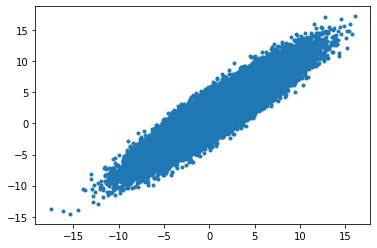

In [4]:
data2 = sample_data_2()
plt.scatter(data2[:, 0], data2[:, 1], marker='.')

## Models

### Model 1 - Diagonal covariance matrix

In [5]:
class NetConfig1(nn.Module):
    
    def __init__(self, n_layers=3, n_features=128):
        super(NetConfig1, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(2, self.n_features))
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, 4)
            
    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var)
        return mu, var

### Model 2 - Diagonal covariance matrix with identical diagonal entries 

In [6]:
class NetConfig2(nn.Module):
    
    def __init__(self, n_layers=3, n_features=128):
        super(NetConfig2, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(2, self.n_features))
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, 3)
            
    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var * torch.ones([1, 2], dtype=torch.float32).cuda())
        return mu, var

In [7]:
""" Helper functions for training and visualization
"""
    
def log_prob(x, mu, var):
    return torch.sum(-0.5 * (torch.log(np.pi * 2 * var) + torch.pow(x - mu, 2) / var), dim=1, keepdim=True)


def train(encoder, decoder, data, n_epoch=10, lr=1e-3, batch_size=125):
    train_size = data.shape[0]
    n_iter_per_epoch = train_size // batch_size

    enc_optim = optim.Adam(encoder.parameters(), lr=lr)
    dec_optim = optim.Adam(decoder.parameters(), lr=lr)

    train_log_kl = []
    train_log_dec = []
    train_log_vlb = []

    for i in range(n_epoch):
        idx = np.random.permutation(train_size)
        for j in range(n_iter_per_epoch):
            batch = torch.from_numpy(data[idx[j * batch_size : (j + 1) * batch_size]]).float().cuda()

            mu_z, var_z = encoder(batch)

            epsilon = torch.randn(batch.shape).cuda()
            sampled_z = mu_z + epsilon * torch.sqrt(var_z)

            mu_x, var_x = decoder(sampled_z)

            nll = -torch.sum(log_prob(batch, mu_x, var_x), dim=1, keepdim=True)

            kl_div = 1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z
            kl_div = -0.5 * torch.sum(kl_div, dim=1, keepdim=True)

            loss = torch.mean(nll + kl_div)

            enc_optim.zero_grad()
            dec_optim.zero_grad()
            loss.backward()
            enc_optim.step()
            dec_optim.step()

            train_log_dec.append(torch.mean(nll).detach().item() / 2.0)
            train_log_kl.append(torch.mean(kl_div).detach().item())
            train_log_vlb.append(torch.mean(-loss).detach().item())
#         print("Epoch-{:d}/{:d} Iteration-{:d}/{:d} Loss-{:.5f}".format(i + 1, n_epoch, j + 1, n_iter_per_epoch, loss.item()))
    return train_log_vlb, train_log_kl, train_log_dec


def visualize_curves(train_log_vlb, train_log_kl, train_log_dec):
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(10, 10))

    ax = plt.subplot(gs[0])
    l = len(train_log_vlb)
    ax.plot(np.arange(l), train_log_vlb)
    ax.set_xlabel("Iterations")
    ax.set_title("VLB")

    ax = plt.subplot(gs[1])
    l = len(train_log_kl)
    ax.plot(np.arange(l), train_log_kl)
    ax.set_xlabel("Iterations")
    ax.set_title("KL-divergence")

    ax = plt.subplot(gs[2])
    l = len(train_log_dec)
    ax.plot(np.arange(l), train_log_dec)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("bits/dim")
    ax.set_title("Decoder term")
    
    
def sample(decoder, n_samples=100000):
    z = torch.randn([n_samples, 2]).cuda()
    mu_x, var_x = decoder(z)
    noisy_x = torch.randn([n_samples, 2]).cuda() * torch.sqrt(var_x) + mu_x
    return noisy_x, mu_x


def visualize_samples(noisy_x, mu_x):
    noisy_x = noisy_x.cpu().data.numpy()
    mu_x = mu_x.cpu().data.numpy()
    plt.scatter(noisy_x[:, 0], noisy_x[:, 1], marker='.', label="Full path samples")
    plt.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', label="Mean")
    plt.legend()

### Configuration 1 - Dataset 1

In [8]:
encoder = NetConfig1().cuda()
decoder = NetConfig1().cuda()
train_log_vlb, train_log_kl, train_log_dec = train(encoder, decoder, data1)

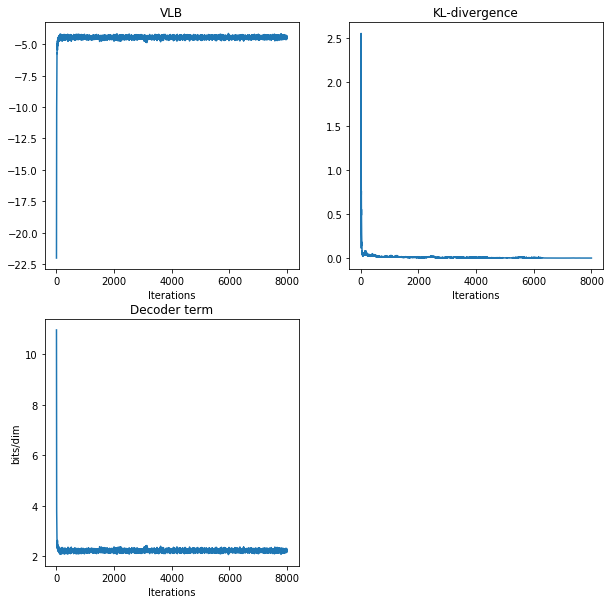

In [9]:
visualize_curves(train_log_vlb, train_log_kl, train_log_dec)

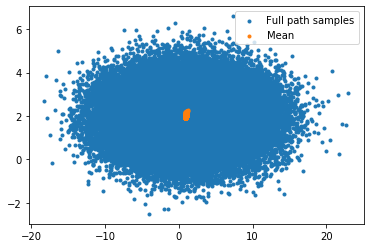

In [10]:
noisy_x, mu_x = sample(decoder, 100000)
visualize_samples(noisy_x, mu_x)

### Configuration 1 - Dataset 2

In [11]:
encoder = NetConfig1().cuda()
decoder = NetConfig1().cuda()
train_log_vlb, train_log_kl, train_log_dec = train(encoder, decoder, data2)

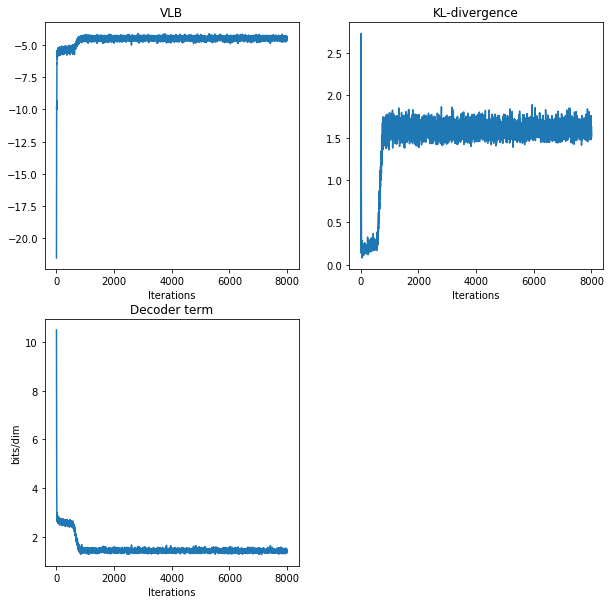

In [12]:
visualize_curves(train_log_vlb, train_log_kl, train_log_dec)

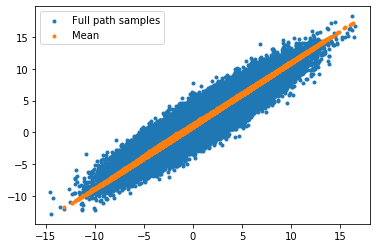

In [13]:
noisy_x, mu_x = sample(decoder, 100000)
visualize_samples(noisy_x, mu_x)

### Configuration 2 - Dataset 1

In [14]:
encoder = NetConfig1().cuda()
decoder = NetConfig2().cuda()
train_log_vlb, train_log_kl, train_log_dec = train(encoder, decoder, data1)

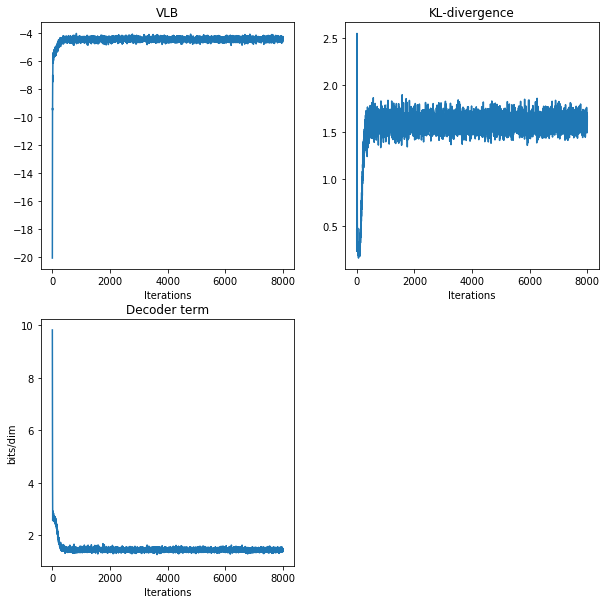

In [15]:
visualize_curves(train_log_vlb, train_log_kl, train_log_dec)

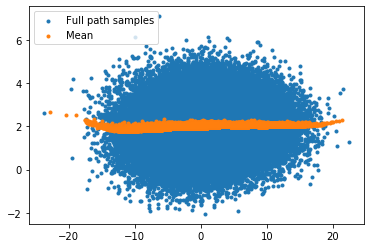

In [16]:
noisy_x, mu_x = sample(decoder, 100000)
visualize_samples(noisy_x, mu_x)

### Configuration 2 - Dataset 2

In [17]:
encoder = NetConfig1().cuda()
decoder = NetConfig2().cuda()
train_log_vlb, train_log_kl, train_log_dec = train(encoder, decoder, data2)

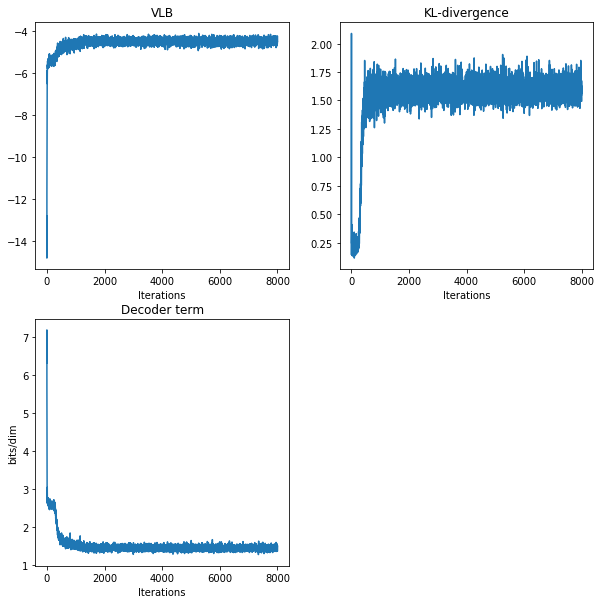

In [18]:
visualize_curves(train_log_vlb, train_log_kl, train_log_dec)

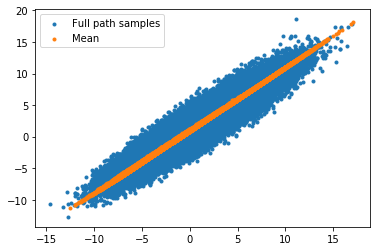

In [19]:
noisy_x, mu_x = sample(decoder, 100000)
visualize_samples(noisy_x, mu_x)

**Question Answering: Is the VAE using the latent code? How do you know? If it does, what about the data does it
capture qualitatively?**

To answer the first question, we can try to calculate the mutual information between the latent code $z$ and data$x$.
$$I(X, Z) = E_{x}[D_{KL}(p(z|x)||p(z))]$$
Since we are approximationg $p(z|x)$ using $q(z|x)$, we have
$$I(X, Z) \simeq E_{x}[D_{KL}(q(z|x)||p(z))]$$
Fortunately, we have already recorded the RHS of the above equation during the training procedure, which is the last value of the list train_log_kl. 

| Experiments      |$$E_{x}[D_{KL}(q(z|x)||p(z))]$$|
| :--------------: | :----------------------------:|
|Config-1 Dataset-1| 0.000588 |
|Config-1 Dataset-2| 1.608624 |
|Config-2 Dataset-1| 1.609415 |
|Config-2 Dataset-2| 1.592691 |

From the table we can see that VAE with configuration 1 and trained on dataset 1 is not using its latent code. This is also clearly shown on the visualization of its output mean value. All datapoints are mapped into a small region that surrounds the mean of the true data distribution.

As for the second question, I'm not sure what 'qualitatively' mean. If 'qualitatively' means how well our model approximates the true data distribution, then both 4 model done this job pretty well, at least visually. I have no idea how to calculate this numerically since integral over the latent code z is intractable.